<a href="https://colab.research.google.com/github/Maxim-Pashkov/ColabLabs/blob/main/LabTimeSeriesDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


Прежде чем начать, убедитесь, что вы используете Python 3 и GPU. В пункте меню *RunTime->Change runtime type* установите нужные параметры. 

Часть кода потребует установки последней версии TensoFlow 2.х. Поэтому убедитесь, что она у вас установлена, запустив ячейку ниже. Если у вас стоит версия Tensorflow 1.х - запустите ячейку сверху этого текста. Если вы это сделете и увидите сообщение о перезапуске runtime, - перезапустите. Убедитесь еще раз, что у вас все еще включены опции Python 3 и GPU, и снова запустите ячейку ниже. В результате вы должны увидеть, что теперь установлен TensoFlow 2.х .

In [2]:
import tensorflow as tf
print(tf.__version__)


2.5.0


Следующий блок кода содержит много того, что вы видели на предыдущих уроках. Он создаст временной ряд `series` с трендом, сезонностью и шумом. Вы увидите этот синтетический временной ряд на графике.

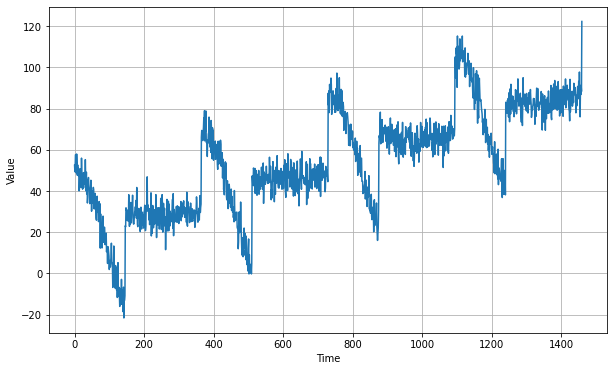

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")

series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [111]:
window_size = 10
batch_size = 32
shuffle_buffer_size = 1000

In [112]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1, activation='relu')                                    
])

In [113]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * (10 ** (epoch / 20)))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks = [lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

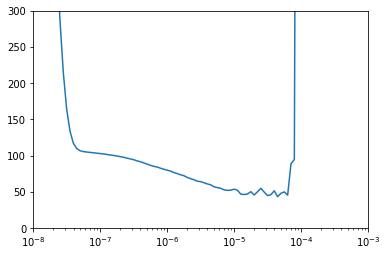

In [114]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20)) 
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])

In [115]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1, activation='relu')                                    
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

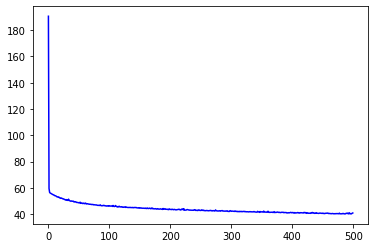

In [116]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.show()

[54.199485778808594, 54.05424880981445, 53.996395111083984, 53.65616226196289, 53.25738525390625, 53.2334098815918, 52.92055130004883, 53.15137481689453, 52.53782653808594, 52.41773223876953, 52.10713195800781, 52.390865325927734, 52.109222412109375, 51.904014587402344, 51.630619049072266, 51.68962860107422, 51.29314422607422, 51.150577545166016, 50.8432502746582, 51.14482498168945, 50.67385482788086, 50.91265106201172, 50.45961380004883, 51.450008392333984, 50.43155288696289, 50.33133316040039, 49.99749755859375, 49.928897857666016, 50.13257598876953, 49.9227409362793, 49.8895263671875, 49.94976043701172, 49.296810150146484, 49.57700729370117, 49.41181564331055, 49.47200012207031, 48.98619842529297, 48.96136474609375, 48.954593658447266, 48.77336120605469, 48.65987777709961, 48.624969482421875, 49.17269515991211, 48.308414459228516, 48.47832489013672, 48.556541442871094, 48.141902923583984, 48.207942962646484, 48.48894119262695, 48.01771545410156, 48.12788391113281, 48.49082946777344,

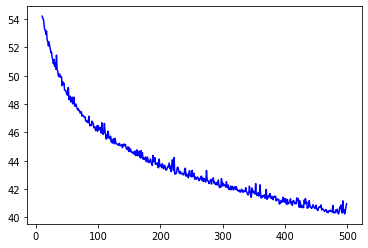

In [118]:
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label = 'Training loss')
plt.show()

In [119]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

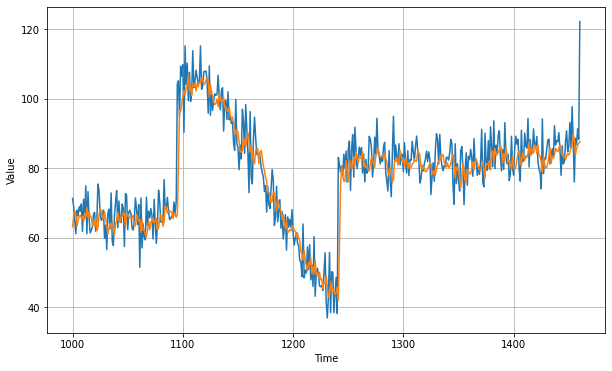

In [120]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [121]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.850637